In [1]:
# check chainer info
%%bash
python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.15.0-36-generic-x86_64-with-debian-stretch-sid
Chainer: 5.0.0
NumPy: 1.13.3
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 9000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : None
iDeep: Not Available


In [4]:
# setting datasets
from chainer.datasets import mnist

train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

label: 5


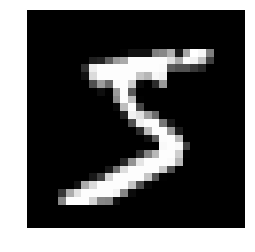

In [13]:
# display data
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train_val[0] # (data, label)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show
print('label:', t)

In [22]:
# divide data, Training and Validation
from chainer.datasets import split_dataset_random
train, valid = split_dataset_random(train_val, 50000, seed=0) # seed値でランダムな値を固定
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('test dataset size:', len(test))

Training dataset size: 50000
Validation dataset size: 10000
test dataset size: 10000


In [23]:
# minibatch processing
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid,
    batchsize,
    repeat=False,
    shuffle=False
)
test_iter = iterators.SerialIterator(
    test,
    batchsize,
    repeat=False,
    shuffle=False,
)

In [25]:
# make neuralnetwork Link and Function
import chainer.links as L # パラメータを持つ関数
import chainer.functions as F # パラメータを持たない関数